In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from PyAstronomy import pyasl
from astropy.io import fits

In [2]:
df  = pd.read_csv('combined_rvs_1.csv')
bjd = df['jd_drp']
rv_drp = df['rv_drp']*1000
σrv = df['σrv_drp']*1000
rv_template = df['rv_template']
rv_by_order = df.iloc[:,75::2].values
σrv_by_order = df.iloc[:,76::2].values
RV_gauss = np.loadtxt('./data_v3/RV_gauss.txt')

### Exclude bad observations

#### reject rvs outliers (outside 1-sigma)

In [3]:
def weighted_avg_and_std2(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [4]:
_, rv_drp_std = weighted_avg_and_std2(rv_drp, 1/σrv**2)
rv_drp_median = np.median(rv_drp)
idx_rej_sigma = abs(rv_drp-rv_drp_median) > (2*rv_drp_std)
sum(idx_rej_sigma)

101

#### reject rvs on user-defined dates

In [5]:
dates_to_exclude = [datetime(2021, 6, 4), datetime(2021, 6, 16), datetime(2021, 7, 9), datetime(2021, 7, 10), datetime(2021, 7, 18), datetime(2021, 7, 19)]

idx_rej_bjd = np.zeros(bjd.shape, dtype=bool)

# use pyasl.jdcnv(date)+1 to translate to the corresponding bjd
for date in dates_to_exclude:
    idx = (abs(bjd-pyasl.jdcnv(date)-1)<0.5)
    idx_rej_bjd = idx_rej_bjd | idx
    
sum(idx_rej_bjd)

418

#### all rejects

In [6]:
idx_rej = idx_rej_sigma | idx_rej_bjd
len(idx_rej), sum(idx_rej)

(31795, 434)

### Plot RVs by order

median rv = 0.29; median σrv = 0.19


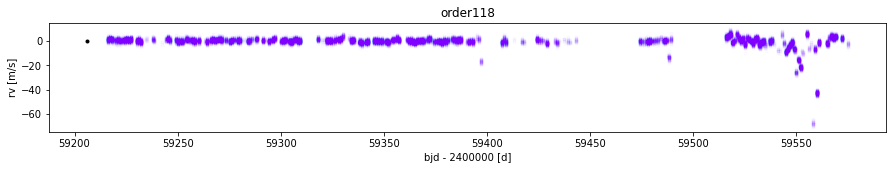

median rv = -0.07; median σrv = 0.21


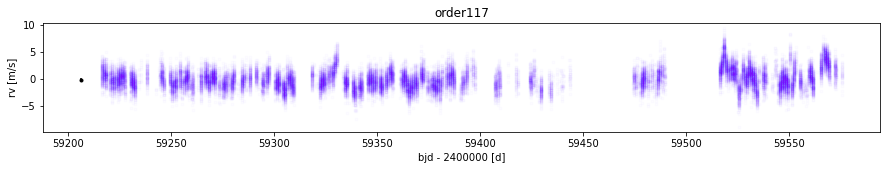

['2021-2-3']
#nan_rv = 147
median rv = 0.39; median σrv = 0.21


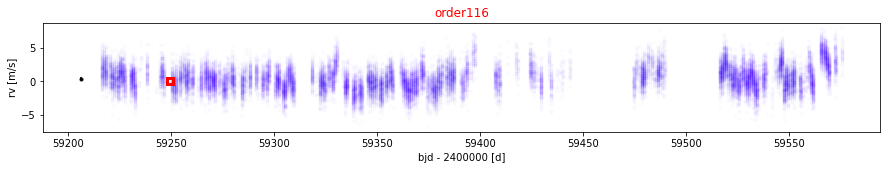

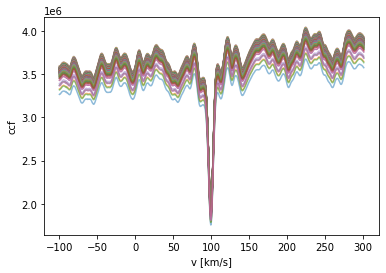

median rv = -0.52; median σrv = 0.21


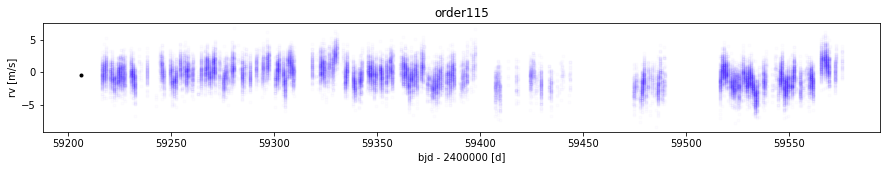

median rv = 0.21; median σrv = 0.23


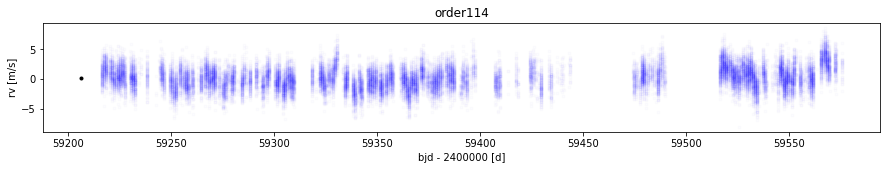

median rv = -1.96; median σrv = 0.25


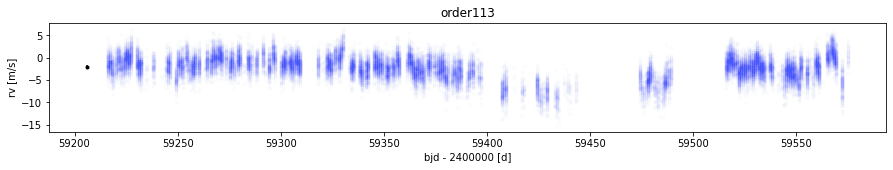

median rv = -0.48; median σrv = 0.32


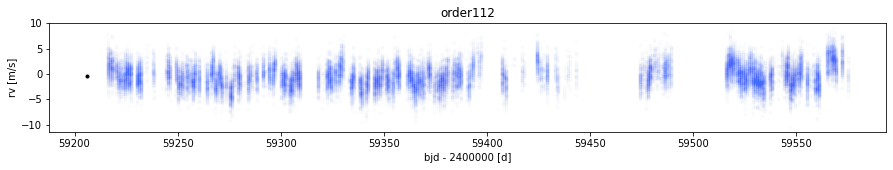

median rv = -0.99; median σrv = 0.28


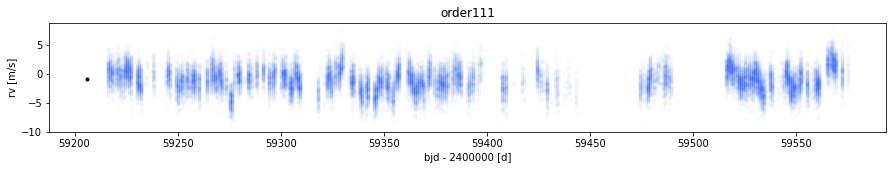

['2021-4-3']
#nan_rv = 224
median rv = -0.60; median σrv = 0.22


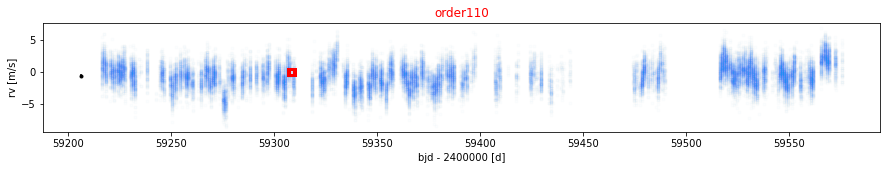

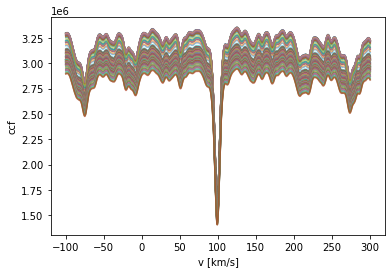

median rv = -0.14; median σrv = 0.30


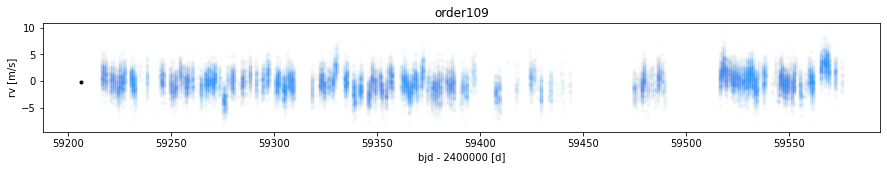

median rv = -0.13; median σrv = 0.32


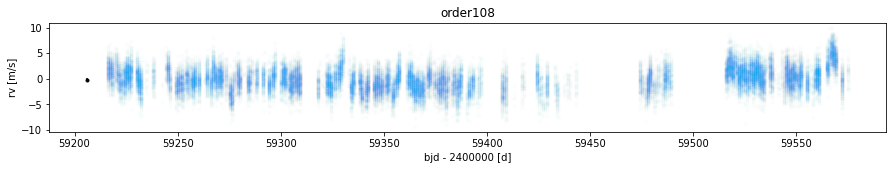

median rv = -1.61; median σrv = 0.42


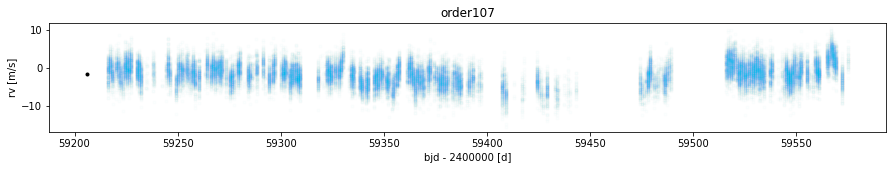

median rv = -0.09; median σrv = 0.46


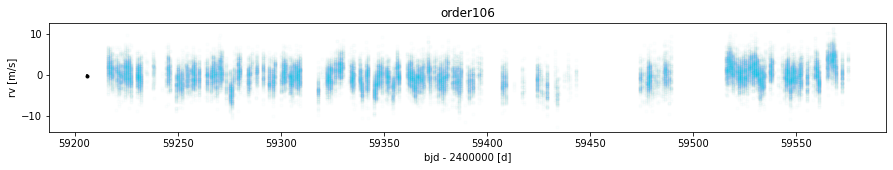

['2021-3-31']
#nan_rv = 224
median rv = -0.19; median σrv = 0.46


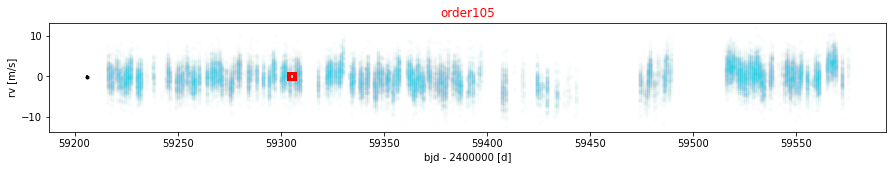

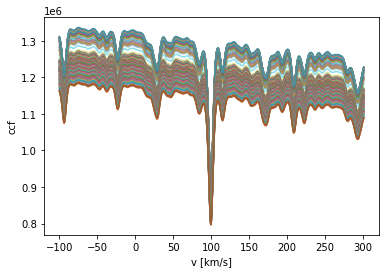

median rv = -4.47; median σrv = 1.54


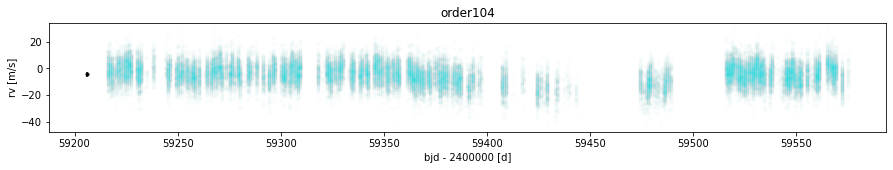

median rv = 0.55; median σrv = 0.46


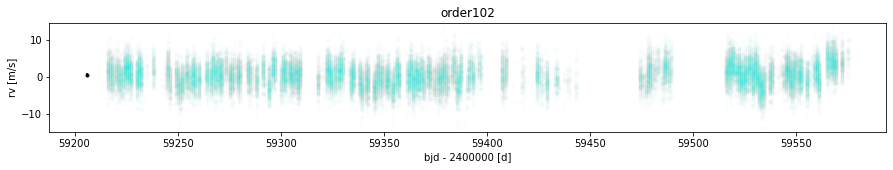

median rv = -0.66; median σrv = 0.42


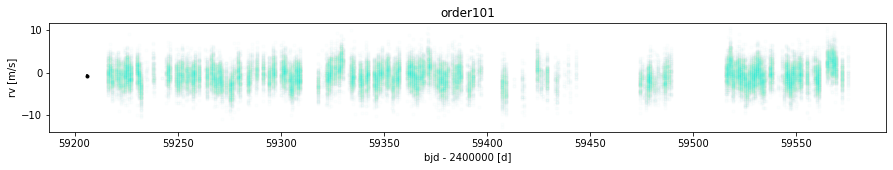

['2021-1-6']
#nan_rv = 165
median rv = 0.44; median σrv = 0.26


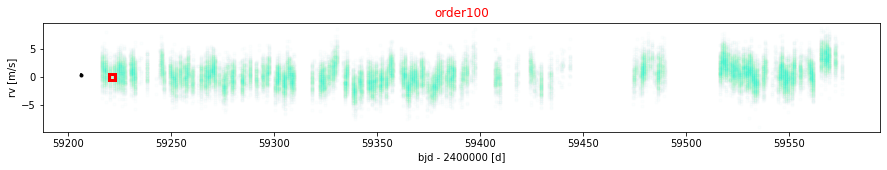

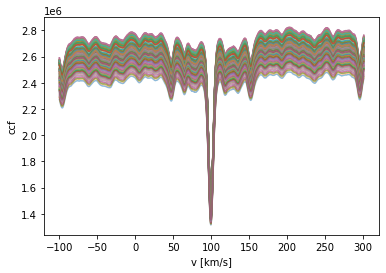

median rv = -0.61; median σrv = 0.28


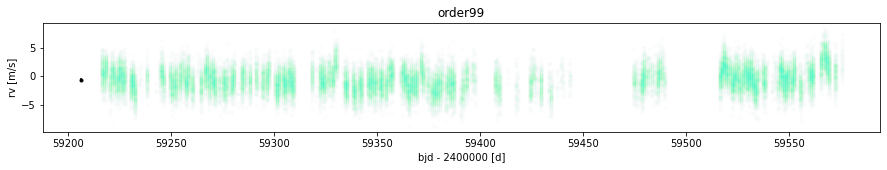

median rv = -0.54; median σrv = 0.29


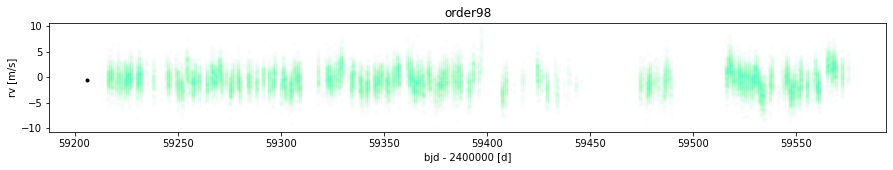

median rv = 0.02; median σrv = 1.45


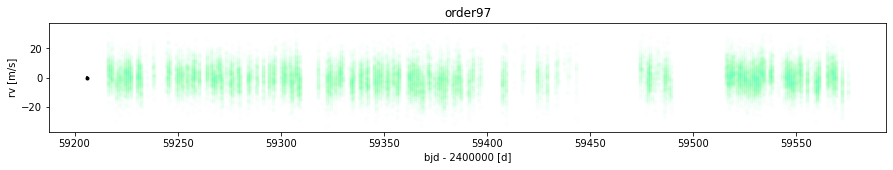

median rv = 0.72; median σrv = 0.39


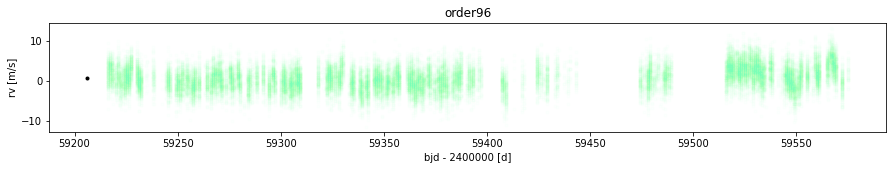

median rv = 0.98; median σrv = 0.85


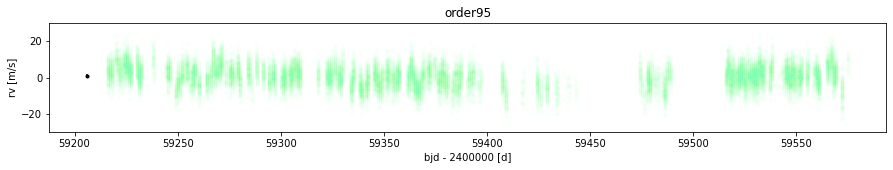

median rv = 7.50; median σrv = 1.19


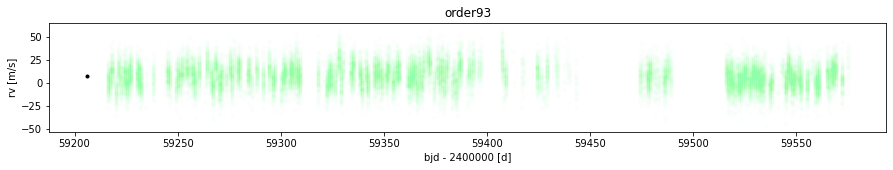

['2021-6-9', '2021-7-28']
#nan_rv = 278
median rv = 2.00; median σrv = 0.54


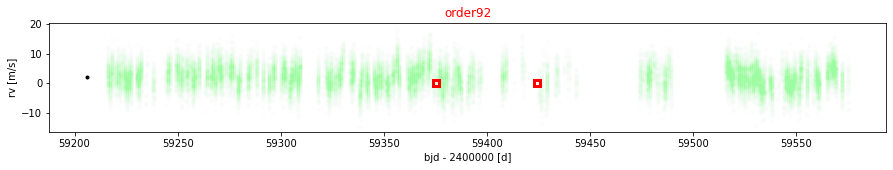

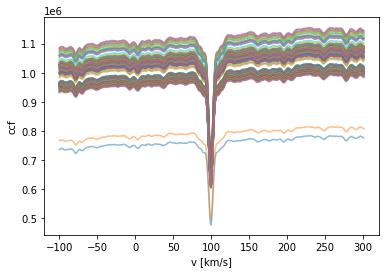

median rv = -0.15; median σrv = 0.52


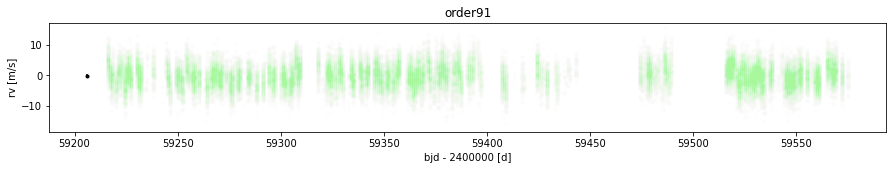

median rv = -0.54; median σrv = 0.68


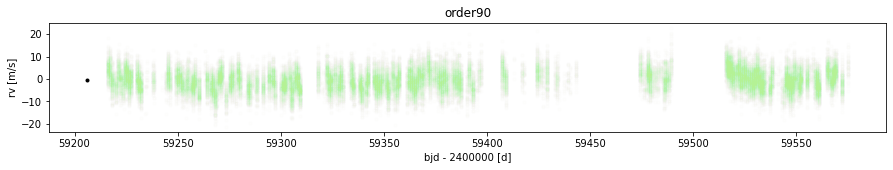

['2021-8-6']
#nan_rv = 43
median rv = 5.60; median σrv = 1.79


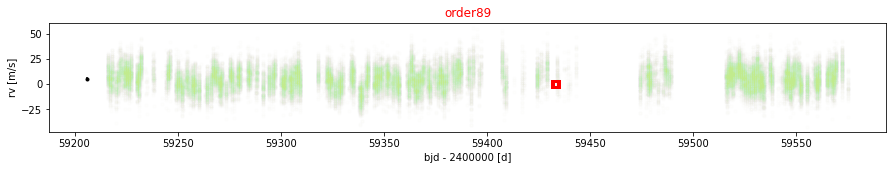

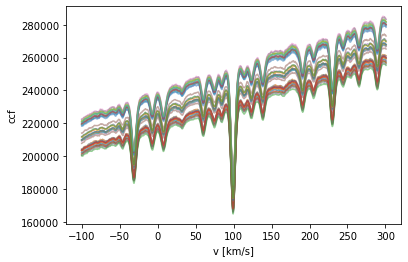

median rv = 3.89; median σrv = 1.85


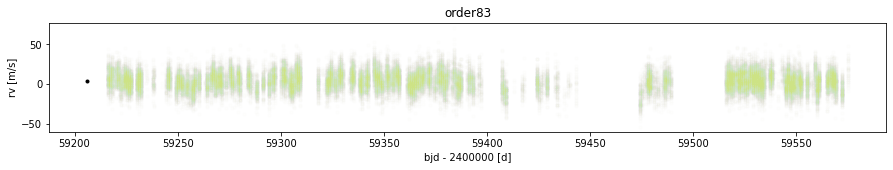

median rv = -0.17; median σrv = 0.41


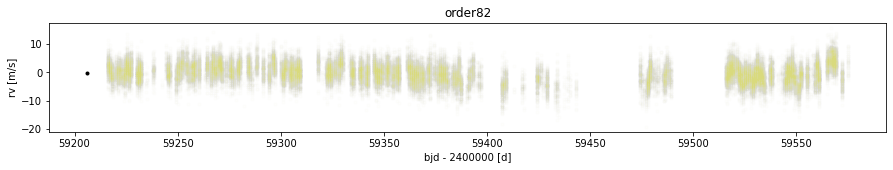

median rv = 2.17; median σrv = 0.47


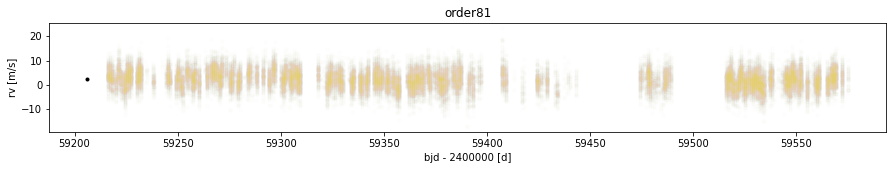

median rv = 1.38; median σrv = 0.59


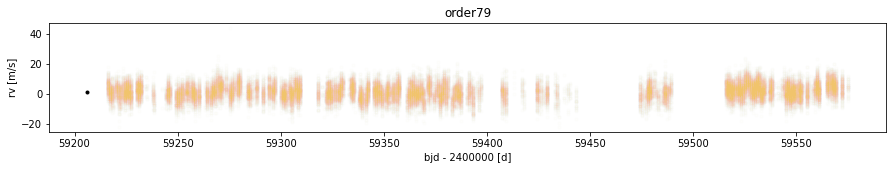

median rv = -2.87; median σrv = 0.85


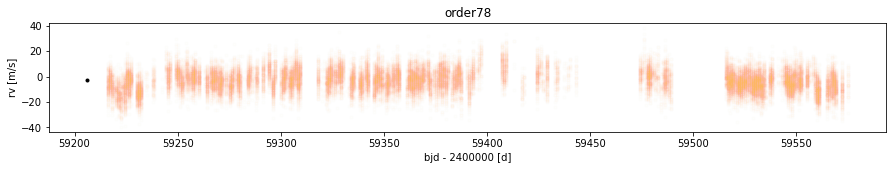

median rv = 30.77; median σrv = 1.09


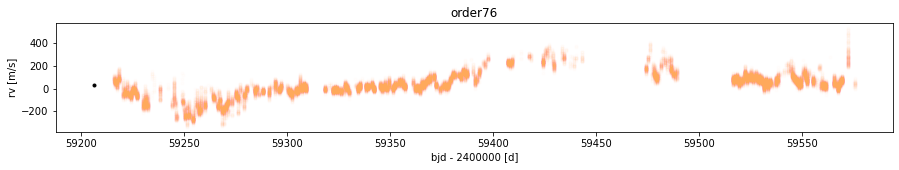

median rv = -12.95; median σrv = 0.44


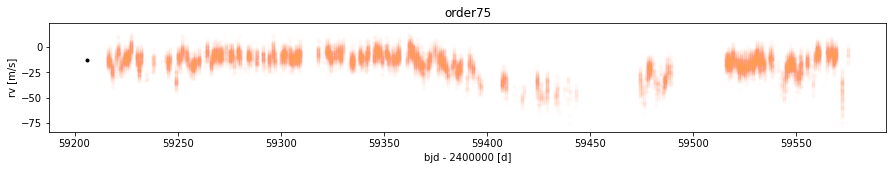

median rv = 38.68; median σrv = 0.59


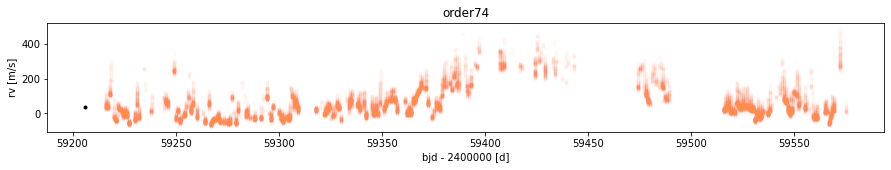

median rv = -0.56; median σrv = 0.54


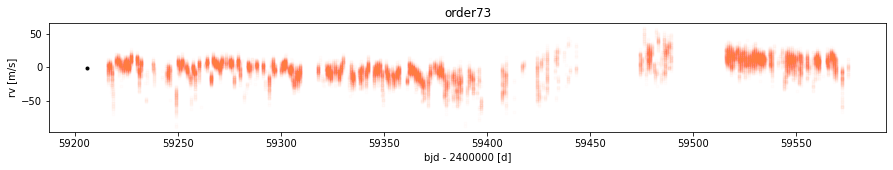

['2021-11-28']
#nan_rv = 245
median rv = 3.77; median σrv = 0.58


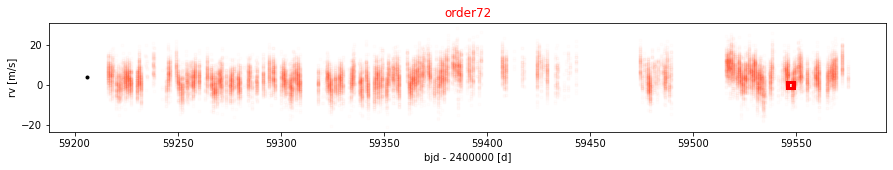

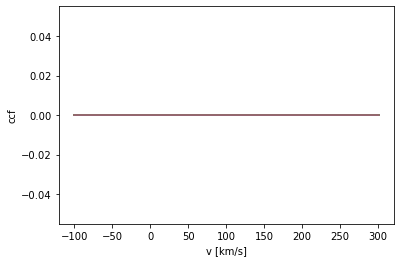

median rv = -1.93; median σrv = 0.52


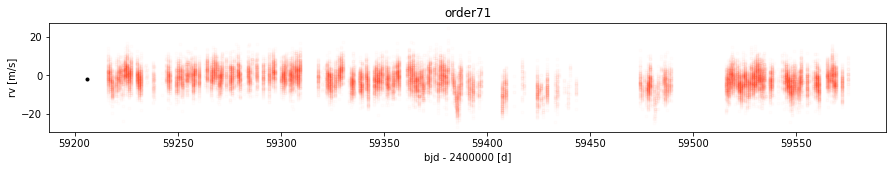

['2021-6-1']
#nan_rv = 151
median rv = -0.74; median σrv = 0.44


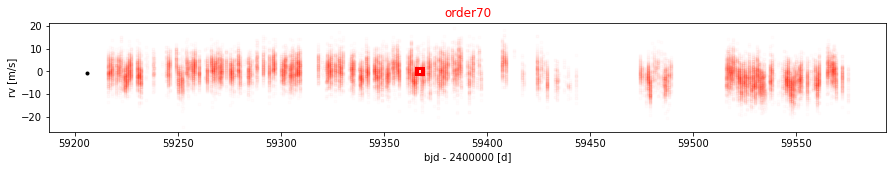

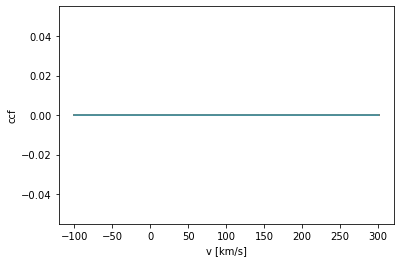

median rv = 4.35; median σrv = 0.70


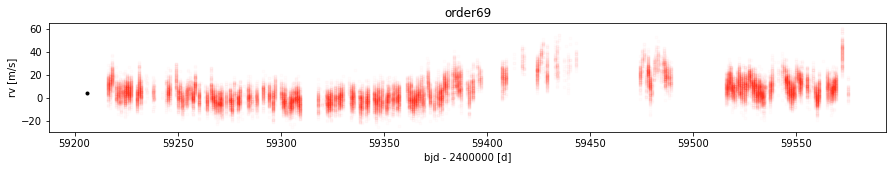

median rv = 88.29; median σrv = 0.45


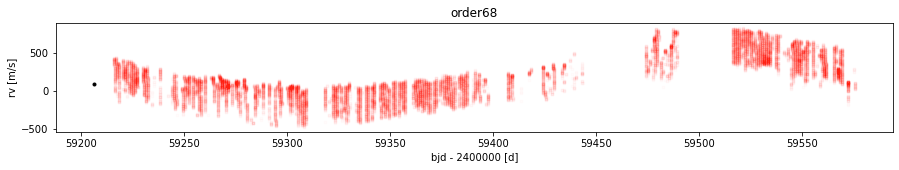

['2021-6-29']
#nan_rv = 31
median rv = 74.84; median σrv = 1.54


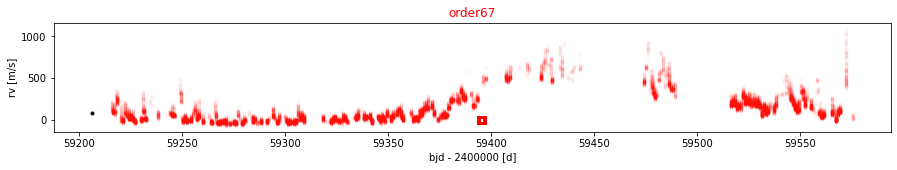

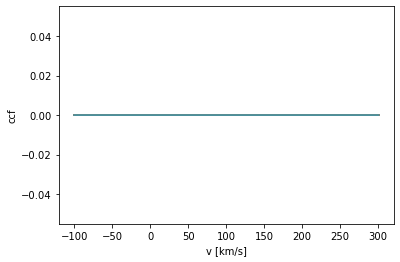

median rv = 10.96; median σrv = 1.07


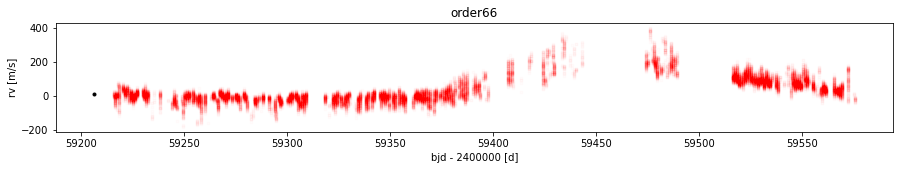

In [7]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, rv_by_order.shape[1]))
title = [title[3:-9] for title in df.columns[75::2]]
idx_nan_all = np.zeros(sum(~idx_rej), dtype=bool)

for i in range(rv_by_order.shape[1]):
# for i in range(3):    
    fig, axes = plt.subplots(figsize=(15, 2))

    # plot rvs by order
    plt.plot(bjd[~idx_rej]-2400000, rv_by_order[~idx_rej,i], '.', alpha=0.01, color=colors[i])

    # label nan values 
    idx_nan = np.isnan(rv_by_order[~idx_rej,i]) | np.isnan(σrv_by_order[~idx_rej,i])
    if sum(idx_nan) == 0:
        plt.title('order' + title[i], color='black')
    else:
        idx_nan_all = idx_nan_all | idx_nan
        Tage = pyasl.daycnv(bjd[~idx_rej][idx_nan])
        print(list(set(['%d-%d-%d' %tuple(einTag)[:3] for einTag in Tage])))
        print('#nan_rv = %d' %sum(idx_nan))
        plt.title('order' + title[i], color='r')
        plt.plot(bjd[~idx_rej][idx_nan]-2400000, np.zeros(sum(idx_nan)), 'rs', mfc='none', mew=3)
        
    # print median rv and σrv per order
    median_rv = np.median(rv_by_order[~idx_rej,i][~idx_nan])
    median_σrv = np.median(σrv_by_order[~idx_rej,i][~idx_nan])
    plt.errorbar(bjd[0]-2400000-10, median_rv, median_σrv, marker='.', c='black')
    print("median rv = %.2f; median σrv = %.2f" %(median_rv, median_σrv))
    
    plt.xlabel('bjd - 2400000 [d]')
    plt.ylabel('rv [m/s]')
    plt.show()

    # check if the corresponding order in the fits files have 0 flux
    if sum(idx_nan) != 0:
        files = df[df['jd_drp'].isin(bjd[~idx_rej][idx_nan])]['Filename']
        yn = True
        for file in files:
            with fits.open(file) as hdulist:
                ccf_per_order = hdulist[12].data
                plt.plot(-100 + np.arange(ccf_per_order.shape[1])*0.25, ccf_per_order[173-int(title[i]),:], alpha=0.5)
        plt.xlabel('v [km/s]')
        plt.ylabel('ccf')
        plt.show()

All dates with nan

In [8]:
Tage_mit_nan = pyasl.daycnv(bjd[~idx_rej][idx_nan_all])
print(list(dict.fromkeys(['%d-%d-%d' %tuple(einTag)[:3] for einTag in Tage_mit_nan])))
print('#nan = %d' %sum(idx_nan_all))

['2021-1-6', '2021-2-3', '2021-3-31', '2021-4-3', '2021-6-1', '2021-6-9', '2021-6-29', '2021-7-28', '2021-8-6', '2021-11-28']
#nan = 1508


### RV comparison

In [9]:
if 0:
    fig, axes = plt.subplots(figsize=(15, 3))
    alpha=0.1

    plt.plot(bjd[~idx_rej]-2400000, rv_drp[~idx_rej]-rv_drp[0], '.', label='rv_drp', alpha=alpha)
    plt.plot(bjd[~idx_rej]-2400000, rv_template[~idx_rej]-rv_template[0]-10, '.', label='rv_template', alpha=alpha)
    plt.plot(bjd[~idx_rej]-2400000, RV_gauss[~idx_rej]-RV_gauss[0]-20, '.', label='RV_gauss', alpha=alpha)

    plt.legend()
    plt.xlabel('BJD - 2400000 [d]')
    plt.ylabel('m/s')
    plt.show()

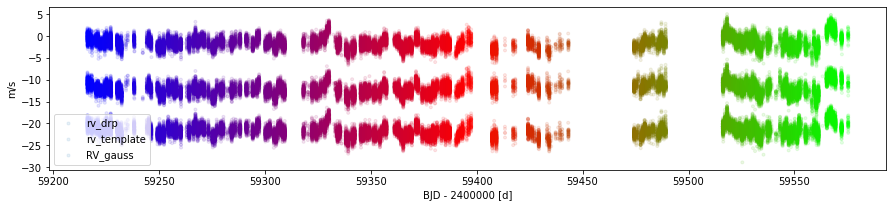

In [10]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.1

bjd_acc = bjd[~idx_rej]
colour = (bjd_acc - min(bjd_acc)) / (max(bjd_acc) - min(bjd_acc))
plt.scatter(bjd_acc-2400000, rv_drp[~idx_rej]-rv_drp[0], marker='.', label='rv_drp', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, rv_template[~idx_rej]-rv_template[0]-10, marker='.', label='rv_template', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, RV_gauss[~idx_rej]-RV_gauss[0]-20, marker='.', label='RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)

plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('m/s')
plt.show()

RV difference 

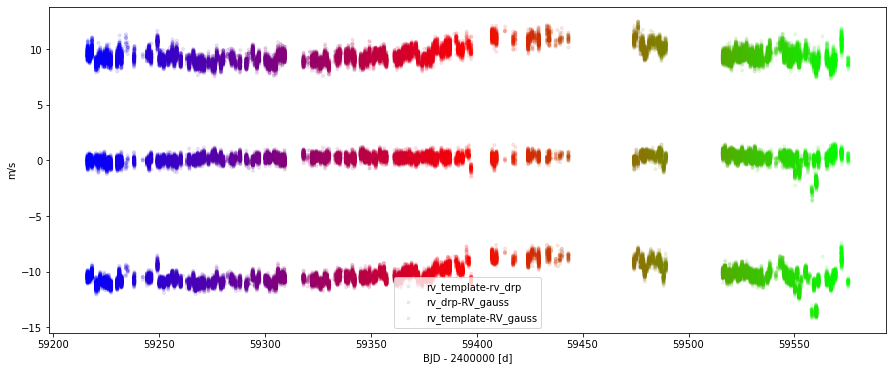

In [11]:
fig, axes = plt.subplots(figsize=(15, 6))
alpha=0.1

plt.scatter(bjd_acc-2400000, (rv_template[~idx_rej]-rv_template[0]) - (rv_drp[~idx_rej]-rv_drp[0])+10, marker='.', label='rv_template-rv_drp', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, (rv_drp[~idx_rej]-rv_drp[0]) - (RV_gauss[~idx_rej]-RV_gauss[0]), marker='.', label='rv_drp-RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)
plt.scatter(bjd_acc-2400000, (rv_template[~idx_rej]-rv_template[0]) - (RV_gauss[~idx_rej]-RV_gauss[0])-10, marker='.', label='rv_template-RV_gauss', alpha=alpha, c=colour, cmap=plt.cm.brg)

plt.legend()
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('m/s')
plt.show()

In [12]:
if 0:
    plt.scatter(rv_drp[~idx_rej], rv_template[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_drp[~idx_rej]), max(rv_drp[~idx_rej])], [min(rv_template[~idx_rej]), max(rv_template[~idx_rej])], 'k-')
    plt.xlabel('rv_drp')
    plt.ylabel('rv_template')
    plt.show()

    plt.scatter(rv_drp[~idx_rej], RV_gauss[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_drp[~idx_rej]), max(rv_drp[~idx_rej])], [min(RV_gauss[~idx_rej]), max(RV_gauss[~idx_rej])], 'k-')
    plt.xlabel('rv_drp')
    plt.ylabel('RV_gauss')
    plt.show()

    plt.scatter(rv_template[~idx_rej], RV_gauss[~idx_rej], marker='.', c=colour, cmap=plt.cm.brg, alpha=0.02)
    plt.plot([min(rv_template[~idx_rej]), max(rv_template[~idx_rej])], [min(RV_gauss[~idx_rej]), max(RV_gauss[~idx_rej])], 'k-')
    plt.xlabel('rv_template')
    plt.ylabel('RV_gauss')
    plt.show()